<a href="https://colab.research.google.com/github/bhattacharya5/Computer_Vision/blob/main/Major_ComputerVision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dlib
!pip install opencv-contrib-python
!pip install imutils

In [ ]:
import os
import requests
import tarfile

# URL of the file to download
url = "http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz"

# Function to download and extract the file
def download_and_extract(url, target_folder):
    # Create the target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Download the file
    file_name = url.split('/')[-1]
    file_path = os.path.join(target_folder, file_name)
    with open(file_path, "wb") as f:
        response = requests.get(url)
        f.write(response.content)

    # Extract the contents
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(target_folder)

    print("File downloaded and extracted successfully!")

# Specify the target folder
target_folder = "./ibug_dataset"

# Call the function to download and extract the file
download_and_extract(url, target_folder)

File downloaded and extracted successfully!


In [ ]:
import os

def tree(directory):
    print(directory)
    print("|")
    for root, dirs, files in os.walk(directory):
        #for file in files:
        #    print("|--", file)
        for dir in dirs:
            tree(os.path.join(root, dir))

# Specify the directory you want to view
directory = "."  # Current directory

# Call the function to display the tree
tree(directory)

.
|
./.config
|
./.config/configurations
|
./.config/logs
|
./.config/logs/2024.04.16
|
./.config/logs/2024.04.16
|
./ibug_dataset
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/helen
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/helen/testset
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/helen/trainset
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/lfpw
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/lfpw/testset
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/lfpw/trainset
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/afw
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/ibug
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/helen/testset
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/helen/trainset
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/lfpw/testset
|
./ibug_dataset/ibug_300W_large_face_landmark_dataset/lfpw/trainset
|
./ibug_dataset/ibug_

## Building an “eyes only” shape predictor dataset

In [ ]:
import re

# Define the input and output paths directly here
input_path = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W.xml"
output_path = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/output1.xml"

def parse_xml(input_path, output_path):
  # in the iBUG 300-W dataset, each (x, y)-coordinate maps to a specific
  # facial feature (i.e., eye, mouth, nose, etc.) -- in order to train a
  # dlib shape predictor on *just* the eyes, we must first define the
  # integer indexes that belong to the eyes
  LANDMARKS = set(list(range(36, 48)))

  # to easily parse out the eye locations from the XML file we can
  # utilize regular expressions to determine if there is a 'part'
  # element on any given line
  PART = re.compile("part name='[0-9]+'")

  # load the contents of the original XML file and open the output file
  # for writing
  print("[INFO] parsing data split XML file...")
  with open(input_path, "r") as file:
      rows = file.readlines()

  with open(output_path, "w") as output:
      # loop over the rows of the data split file
      for row in rows:
          # check to see if the current line has the (x, y)-coordinates for
          # the facial landmarks we are interested in
          parts = re.findall(PART, row)

          # if there is no information related to the (x, y)-coordinates of
          # the facial landmarks, we can write the current line out to disk
          # with no further modifications
          if len(parts) == 0:
              output.write(row)
          # otherwise, there is annotation information that we must process
          else:
              # parse out the name of the attribute from the row
              attr = "name='"
              i = row.find(attr)
              j = row.find("'", i + len(attr) + 1)
              name = int(row[i + len(attr):j])

              # if the facial landmark name exists within the range of our
              # indexes, write it to our output file
              if name in LANDMARKS:
                  output.write(row)

  print("Processing completed. Output saved to:", output_path)


parse_xml (input_path, output_path)

[INFO] parsing data split XML file...
Processing completed. Output saved to: /content/ibug_dataset/ibug_300W_large_face_landmark_dataset/output1.xml


## Creating our training and testing splits

In [ ]:
# Paths to the input and output files
train_input_path = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml"
train_output_path = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train_eyes.xml"
test_input_path = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml"
test_output_path = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_eyes.xml"

# Parsing train data
parse_xml(train_input_path, train_output_path)

# Parsing test data
parse_xml(test_input_path, test_output_path)

[INFO] parsing data split XML file...
Processing completed. Output saved to: /content/ibug_dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train_eyes.xml
[INFO] parsing data split XML file...
Processing completed. Output saved to: /content/ibug_dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_eyes.xml


## Implementing our custom dlib shape predictor training script

In [ ]:
import multiprocessing
import dlib

def train_shape_predictor(training_xml, model_path):
    # grab the default options for dlib's shape predictor
    print("[INFO] setting shape predictor options...")
    options = dlib.shape_predictor_training_options()

    # Hyperparameters to tune:
    # tree_depth: Depth of each regression tree
    options.tree_depth = 4

    # nu: Regularization parameter
    options.nu = 0.1

    # cascade_depth: Number of cascades used to train the shape predictor
    options.cascade_depth = 15

    # feature_pool_size: Number of pixels used to generate features for the random trees at each cascade
    options.feature_pool_size = 400

    # num_test_splits: Number of test splits
    options.num_test_splits = 50

    # oversampling_amount: Controls the amount of "jitter" (data augmentation) when training the shape predictor
    options.oversampling_amount = 5

    # oversampling_translation_jitter: Amount of translation jitter to apply
    options.oversampling_translation_jitter = 0.1

    # be_verbose: Whether to print out status messages during training
    options.be_verbose = True

    # num_threads: Number of threads/CPU cores to be used when training
    options.num_threads = multiprocessing.cpu_count()

    # Log the training options
    print("[INFO] Shape predictor options:")
    print(options)

    # Train the shape predictor
    print("[INFO] Training shape predictor...")
    dlib.train_shape_predictor(training_xml, model_path, options)
    print("[INFO] Training completed.")

# Paths to training data and model output
training_xml = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train_eyes.xml"
model_path = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/custom_shape_predictor.dat"

# Train the shape predictor
train_shape_predictor(training_xml, model_path)


[INFO] setting shape predictor options...
[INFO] Shape predictor options:
shape_predictor_training_options(be_verbose=1, cascade_depth=15, tree_depth=4, num_trees_per_cascade_level=500, nu=0.1, oversampling_amount=5, oversampling_translation_jitter=0.1, feature_pool_size=400, lambda_param=0.1, num_test_splits=50, feature_pool_region_padding=0, random_seed=, num_threads=2, landmark_relative_padding_mode=1)
[INFO] Training shape predictor...
[INFO] Training completed.


## Implementing our shape predictor evaluation

In [ ]:
import dlib

# Set the paths directly
predictor_path = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/custom_shape_predictor.dat"
xml_path = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_eyes.xml"

# Compute the error over the supplied data split
print("[INFO] evaluating shape predictor...")
error = dlib.test_shape_predictor(xml_path, predictor_path)
print("[INFO] error: {}".format(error))


[INFO] evaluating shape predictor...
[INFO] error: 8.496729333248092


### shape predictor inference

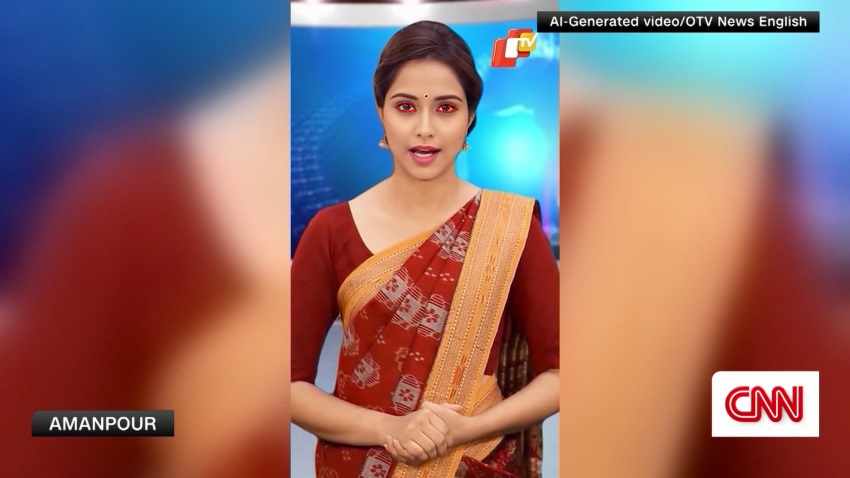

In [ ]:
import cv2
import dlib
from imutils import face_utils
from google.colab.patches import cv2_imshow

# Load the shape predictor model
shape_predictor_path = "/content/ibug_dataset/ibug_300W_large_face_landmark_dataset/custom_shape_predictor.dat"
predictor = dlib.shape_predictor(shape_predictor_path)

# Load the input image
image_path = "/content/test.jpg"  # Replace "path_to_your_image.jpg" with the path to your image
image = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize the face detector
detector = dlib.get_frontal_face_detector()

# Detect faces in the grayscale image
rects = detector(gray, 0)

# Loop over the face detections
for rect in rects:
    # Predict the facial landmarks
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    # Loop over the (x, y)-coordinates from the shape and draw them on the image
    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

# Display the image with the detected landmarks
cv2_imshow(image)
